In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# Read in our dataset - names in this example
words = open('names.txt', 'r').read().splitlines()
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [8]:
# Dataset Building

# Context Length - how many characters we use to predict
block_size = 3

def build_dataset(words):
  X, Y = [], []

  # for all words in the dataset we append the next words to create our context and add it to our X
  for w in words:
    # Depending on our context lenght we initialise it to just 0
    # We are using 0 here as it is the defined special character index
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  
  # Append this
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


# Creating our dataset function will simply take the dataset and convert the words into characters
# based on the context so what we can do is simply divide the dataset words into separate sections based on the length

#Randomly shuffle our words
import random
random.seed(42)
random.shuffle(words)

length = len(words)
n1 = int(0.8 * length)
n2 = int(0.9 * length)

# Now we have our training, dev/validation, testing datasets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [10]:
# Improving using batch normalisation and initialisations
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

# If we start scaling the weights by * 0.01 we are getting values very close to 0 and thus a uniform distribution
# The reason we don't usually initialise all weights to 0 (which is perfectly a uniform distribution)
# Things can go wrong very quickly
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Here we can scale by the recommended standard deviation
# 5/3 is the recommended gain for tanh and divided by the squareroot of the fan in
# fan in is the number of embeddings * block size - this is the kaiming init for our tahn non linearity
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)

# There is no point in us using our biases as the batch normalisation will remove these biases (if you check the gradients they will be 0)
# It is simply just a useless wasteful bias that is not necessary - batch normalisation has its own bias
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01


W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
# We want values to be roughly 0 and we don't want a bias of random numbers so we can initalise them at 0
# can also start with .zeros (would be more efficient)
b2 = torch.randn(vocab_size,                      generator=g) * 0

12097


In [ ]:
# By taking most of the logits to close to 0 we remove the hockey stick effect from the neural network

# tahn will tend to make a majority of the values +1 or -1

# Improvements to the network - essentially minimising unproductive training in the network
# original 
# train 2.12
# val 2.17

# fixed the softmax being confidently wrong by mapping biases to 0 adn weights to * 0.01
# we dont waste time doing the squishing and easy learning
# train 2.07
# val 2.13

# fixing tanh layer being too saturated at initialisation - we apply the same fix to tanh
# kaiming init - no need to introduce any magic numbers (no guessing, and kaiming init is principled)
# Prevents us getting any dead neurons
# train 2.03
# val 2.10

In [ ]:
# BatchNorm - allows us to train very very deep neural networks quite reliably

# we want these to be roughly gaussian but only at initialisation
# However we want our network to have freedom to allow it to move arround and we can have the backpropagation tell us 
# How we can allow it to move around - ther is a scale and shift we can scale the normalised value adn shifting it
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [14]:
# During initialisation, we dont want our logits to be any positive or negative number, otherwise
# during initialisation we get a very very bad confidence
# Initiallly we are expecting not extreme values or a fake confidence that gives bad loss
# We want the initialised values to be roughly 0 so that exp(0) =1 and we get a uniform distribution

# If we are just using this scaling method for initialisation and mapping a majority of hte vlaues to near 0
# we are going to get a majority -1 and 1 - the values are mostly around +15 and -15
# plt.hist(activation_layer.view(-1).to_list(), 50)

# The problem here is the distribution of tanh activations.
# if the derivative of tanh is close to 0 which it will be when we have -1 or +1 then we will effectively get gradients vanishing
# We can fix this with batch normalisation

# If all examples land in the tail of the neuron, then if we have columns of completely white then we have 
# a dead neuron and thus if none of the values land in the active region it will never learn
#ReLU neurons can make it so twe have neurons that never turn on
# Leaky ReLU does not suffer from flat neurons either, it

In [ ]:
# Kaiming Initialisation

# We want to preserve a unit gaussian distribution with standard deviation of 1
# kaiming willl take the number of fan_in preserving the gradietns in the forwarde pass and then we
# have to pass in our non-linearity
# Depending on the non linearity there is a gain that affects how much it will be scaled by
# tahn is hte applied h - a contractive transforamtion, it is squashing by taking the tails
# we need to boost the weights so that we get a unit standard deviation

# Not as important to calibrate our neural net, in practice normalising by the sqrt of the fan in is good enough
# but if we want to be exactly accurate we should do it by torch.nn.init.kaiminig_normal_

In [12]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # customary to add this batch normalisation layer afer every single linear layer - significantly stabilises the training
  # The minibatch training using batch norm it is introducing entropy and htus can be thought of as data augmentation
  # and perhaps even a regulariser as it makes it harder for the neural network to overfit

  # BatchNorm
  # We have hidden stantes taht want to be roughyl gaussian
  # Take hidden states and normalised them to be unit gaussian, making them gaussian is able to be differentiable and thus is okay
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # Each neurons firing value will be exactly unit gaussian initially
  # When estimating our batch normalisation - the paper states that we should include epsilon so that in the case that
  # we are dividing by zero variance we dont get an error and it will behave better
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

  # Layer / instance / group normalisation do not couple batches - however reason it works quite well is due to regularisation effect
  # Without updating the gradients, we can slowly approximate the our mean and standard deviation by adding small increments to out value
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # Non-linearity tanh
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)

  # backward pass - make sure our gradients are always 0
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307


KeyboardInterrupt: 

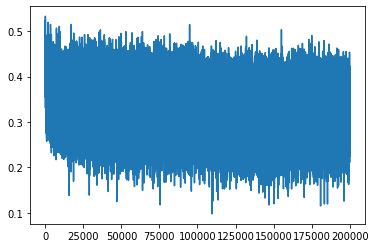

In [ ]:
plt.plot(lossi)

In [ ]:
# Batch norm calibration - can either be estimated on the side of training or recalculated on the entire dataset
# Instead of recalculating it oover the whole dataset
# On the side of training we can also approximate its calculation

# Make sure we are not updating our gradietns
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1

  # measure the mean/std over the entire training set - this will get the fixed numbers and thus calibrate our batch norm
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [ ]:
# Hence during test time we now have the calibrated and fixed tensors that are being used for batch normalisation
# They do not have to be recalculated
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674147605895996
val 2.1056840419769287


In [ ]:
"""
## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491
"""

In [ ]:
# If we have a small batch size then we want our batch normalisation momentum to be quite small as they will be very different
# this could also be dangerous and you would introduce some thrashing
# Besides using a decorator @torch.no_grad()
# we can also use a context manager with torch.no_grad()

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    # gamma and beta will be the values that will update the weights and biases
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    
    # We can calculate a running mean and runing variance usding batch normalisation we dont have to recalculate it using the new model on the entire dataset for inference
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) 
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    # This formula will normalise the weights to be unit variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # Update the buffers to calculate the running mean and running variance
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024
